# Portfolio Selection
### For https://www.hslu.ch/de-ch/hochschule-luzern/forschung/projekte/detail/?pid=5520

In [1]:
import math,heapq
import numpy as np
import pandas as pd

from qiskit.circuit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import PhaseGate

from utils.misc import *
from utils.algorithms.phase_estimator import get_t
from utils.algorithms.grover import get_diffuser,GroverSolver
from utils.algorithms.counting import get_count
from utils.gates import GreaterThanGate,PhaseEstimatorGate


In [2]:
no_of_assets_to_consider = 2

data = pd.read_excel('utils/port_opt_data.xlsx')

returns = data.iloc[1:,1:no_of_assets_to_consider+1].pct_change().dropna()
mu = returns.mean().values[:,None]

cov = returns.cov().values

f_risk = lambda x: np.einsum('...i,...i->...', x.T.dot(cov), x.T)
f_return = lambda x: np.dot(mu.T,x).ravel()

def get_sharpe(w):
    portf_return = f_return(w).item()
    portf_std = np.sqrt(f_risk(w))
    return portf_return/portf_std

In [3]:
####################################
s_above = 2
s_below = 1

min_success_chance = 0.97 # desired minimum propagated success chance at the end of quantum counting
c = 10; k_ = 1 # search resolution: d := c^-k_
n_state = 3 # number of grover solution qubits. 2**n_state portfolios will be considered
find_M_exact = False
####################################

# Omega_d = [s_below]
# while Omega_d[-1]<s_above:
#     Omega_d.append(Omega_d[-1]+d)
# Omega_d

d = c**-k_

fail_chance = (1-min_success_chance)/math.ceil(math.log2(s_above-s_below) + k_*math.log2(c))
assert fail_chance < 0.01 , fail_chance
success_chance = 1- fail_chance

N = 2**n_state
if find_M_exact:
    bit_accuracy = math.ceil(np.log2(N) + 0.5) # for quantum counting (M exact)
else:
    bit_accuracy = math.ceil(np.log2(N)/2 + 1.58) # for quantum counting (M not exact)
t = math.ceil(k_*math.log2(c) + math.log2(math.pi)) + 1 # for greater-than / phase estimation
n = n_state + 2*t + 1 # n_state + t (qpe) + t (threshold) + 1 (out)

ws = [np.array([w1,1-w1]) for w1 in np.linspace(0,1,2**n_state)] # N = 2**n_state many portfolios
phases = np.array([*map(get_sharpe,ws)]).round(2)*10 # sharpe ratios of portfolios
# phases = np.array([0.1,0.4,0.2,0.4])
# phases = np.arange(0.1,0.9,0.1)

assert np.all(phases<2*np.pi)
print(phases)
print(t,bit_accuracy,n)

# post-adjustments
success_chance = 0.75



[1.1 1.3 1.4 1.4 1.4 1.3 1.2 1. ]
6 4 16


In [4]:
print('(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no.',np.argmax(phases))

unitary = np.diag([np.e**(i*1j) for i in phases]+(N-len(phases))*[1])
unitary = matrix_to_gate(unitary_mat=unitary,to_gate=True)

grover_eigstate = QuantumCircuit(n)
grover_eigstate.x(-1)
grover_eigstate.h(grover_eigstate.qubits[:n_state]+[n-1])

diffuser = get_diffuser(n_state)

oracle = QuantumCircuit(n)
oracle.compose(PhaseEstimatorGate(unitary,t),inplace=True)
oracle.compose(GreaterThanGate(t),[*range(n_state,t+n_state)]+[*range(t+n_state,2*t+n_state)]+[n-1],inplace=True)
oracle.compose(PhaseEstimatorGate(unitary,t).inverse(),inplace=True)

grover_op = QuantumCircuit(n)
grover_op.compose(oracle.to_gate(),grover_op.qubits,inplace=True)
grover_op.compose(diffuser.to_gate(),grover_op.qubits[:n_state],inplace=True)

# Adjust the grover operator with (classically) obtained oracles at each iteration, 
# until the portfolio with the highest sharpe ratio is found, bzw. its corresponding grover operator
no_of_solutions = 0
while round(s_above - s_below,k_) > d and not no_of_solutions == 1:

    s_threshold = (s_above + s_below) / 2
    s_threshold = round(s_threshold,k_)
    assert s_threshold < 2*math.pi
    print(f"s_above: {s_above} , s_threshold: {s_threshold}, s_below: {s_below}")

    s_threshold_bits = float2binary(s_threshold/2/math.pi,t)
    for k,i in enumerate(s_threshold_bits[::-1]):
        temp = int(i)
        if temp:
            grover_eigstate.x(t+n_state+k)
    
    print('-' * 45)

    no_of_solutions, theta, err = get_count(bit_accuracy,success_chance,grover_op,grover_eigstate,n=n_state)
    
    print('%-14s | %-14s' % ('Measured #Sol', 'Error Bound'))
    print('%-14.1f | %-14.2f' % (no_of_solutions, err))

    no_of_solutions = round(no_of_solutions)
    if no_of_solutions == 0:
        s_above = s_threshold
    else:
        s_below = s_threshold

    for k,i in enumerate(s_threshold_bits[::-1]):
        temp = int(i)
        if temp:
            grover_eigstate.x(t+n_state+k)

print('-' * 45,'\n')

for k,i in enumerate(s_threshold_bits[::-1]):
    temp = int(i)
    if temp:
        grover_eigstate.x(t+n_state+k)

(Classical Calculation) The portfolio with the best sharpe ratio is: portfolio no. 2
s_above: 2 , s_threshold: 1.5, s_below: 1
---------------------------------------------
t:  6 grover_op.num_qubits:  16
Measured #Sol  | Error Bound   
0.0            | 0.01          
s_above: 1.5 , s_threshold: 1.2, s_below: 1
---------------------------------------------
t:  6 grover_op.num_qubits:  16
Measured #Sol  | Error Bound   
5.2            | 0.41          
s_above: 1.5 , s_threshold: 1.4, s_below: 1.2
---------------------------------------------
t:  6 grover_op.num_qubits:  16
Measured #Sol  | Error Bound   
0.0            | 0.01          
s_above: 1.4 , s_threshold: 1.3, s_below: 1.2
---------------------------------------------
t:  6 grover_op.num_qubits:  16
Measured #Sol  | Error Bound   
2.8            | 0.31          
--------------------------------------------- 



Number of calls to the oracle: 1
(Quantum Calculation) The portfolio with the best sharpe ratio is: portfolio no. 3
Note that the bits are shown in reverse order on the histogram.


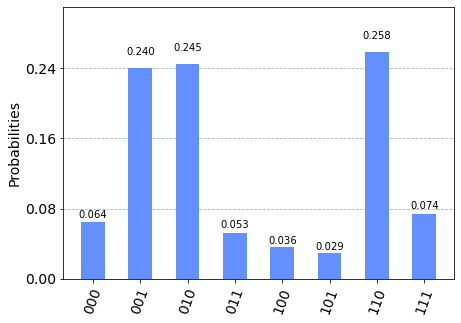

In [5]:
# Now that we have found the correct threshold, we can do amplification. 

assert theta != 0
t_grover = round(0.5 * (np.pi/abs(theta-math.pi) - 1))
# t_grover = round(0.5 * (np.pi/(2*np.arcsin(np.sqrt(no_of_solutions/N))) - 1))
print('Number of calls to the oracle:',t_grover)
circ = QuantumCircuit(grover_op.num_qubits)
circ.compose(grover_eigstate.to_gate(),inplace=True)
for _ in range(t_grover):
    circ.compose(grover_op.to_gate(),inplace=True)

counts = get_counts(circ,circ.qubits[:n_state])

print('(Quantum Calculation) The portfolio with the best sharpe ratio is: portfolio no.',int(max(counts, key=counts.get)[::-1],2))
print('Note that the bits are shown in reverse order on the histogram.')

plot_histogram(counts)


In [19]:
solutions = heapq.nlargest(no_of_solutions,counts,counts.get)
print("Solutions: ",*map(lambda x: int(x[::-1],2),solutions))

Solutions:  3 2 4
